# Stable-Diffusion-Webui Download Helper
Intended to be used with the template of `runpod/stable-diffusion:web-ui-10.1.1` on VastAI. <br>
This notebook is used to asynchronously download files and place them in the proper folder. <br>
By modifying the code, this file can be used for other docker templates or used to download more types of files. 
<br> <br>

#### Running the File
**Ctrl+Enter will run a cell of code. The `Run` Menu can also be used.** <br>
**The symbol `#` indicates a comment that will not executed code.**

### Usage: Step 1

Grab model download links from Civit.AI as show below. Huggingface links can be used aswell.
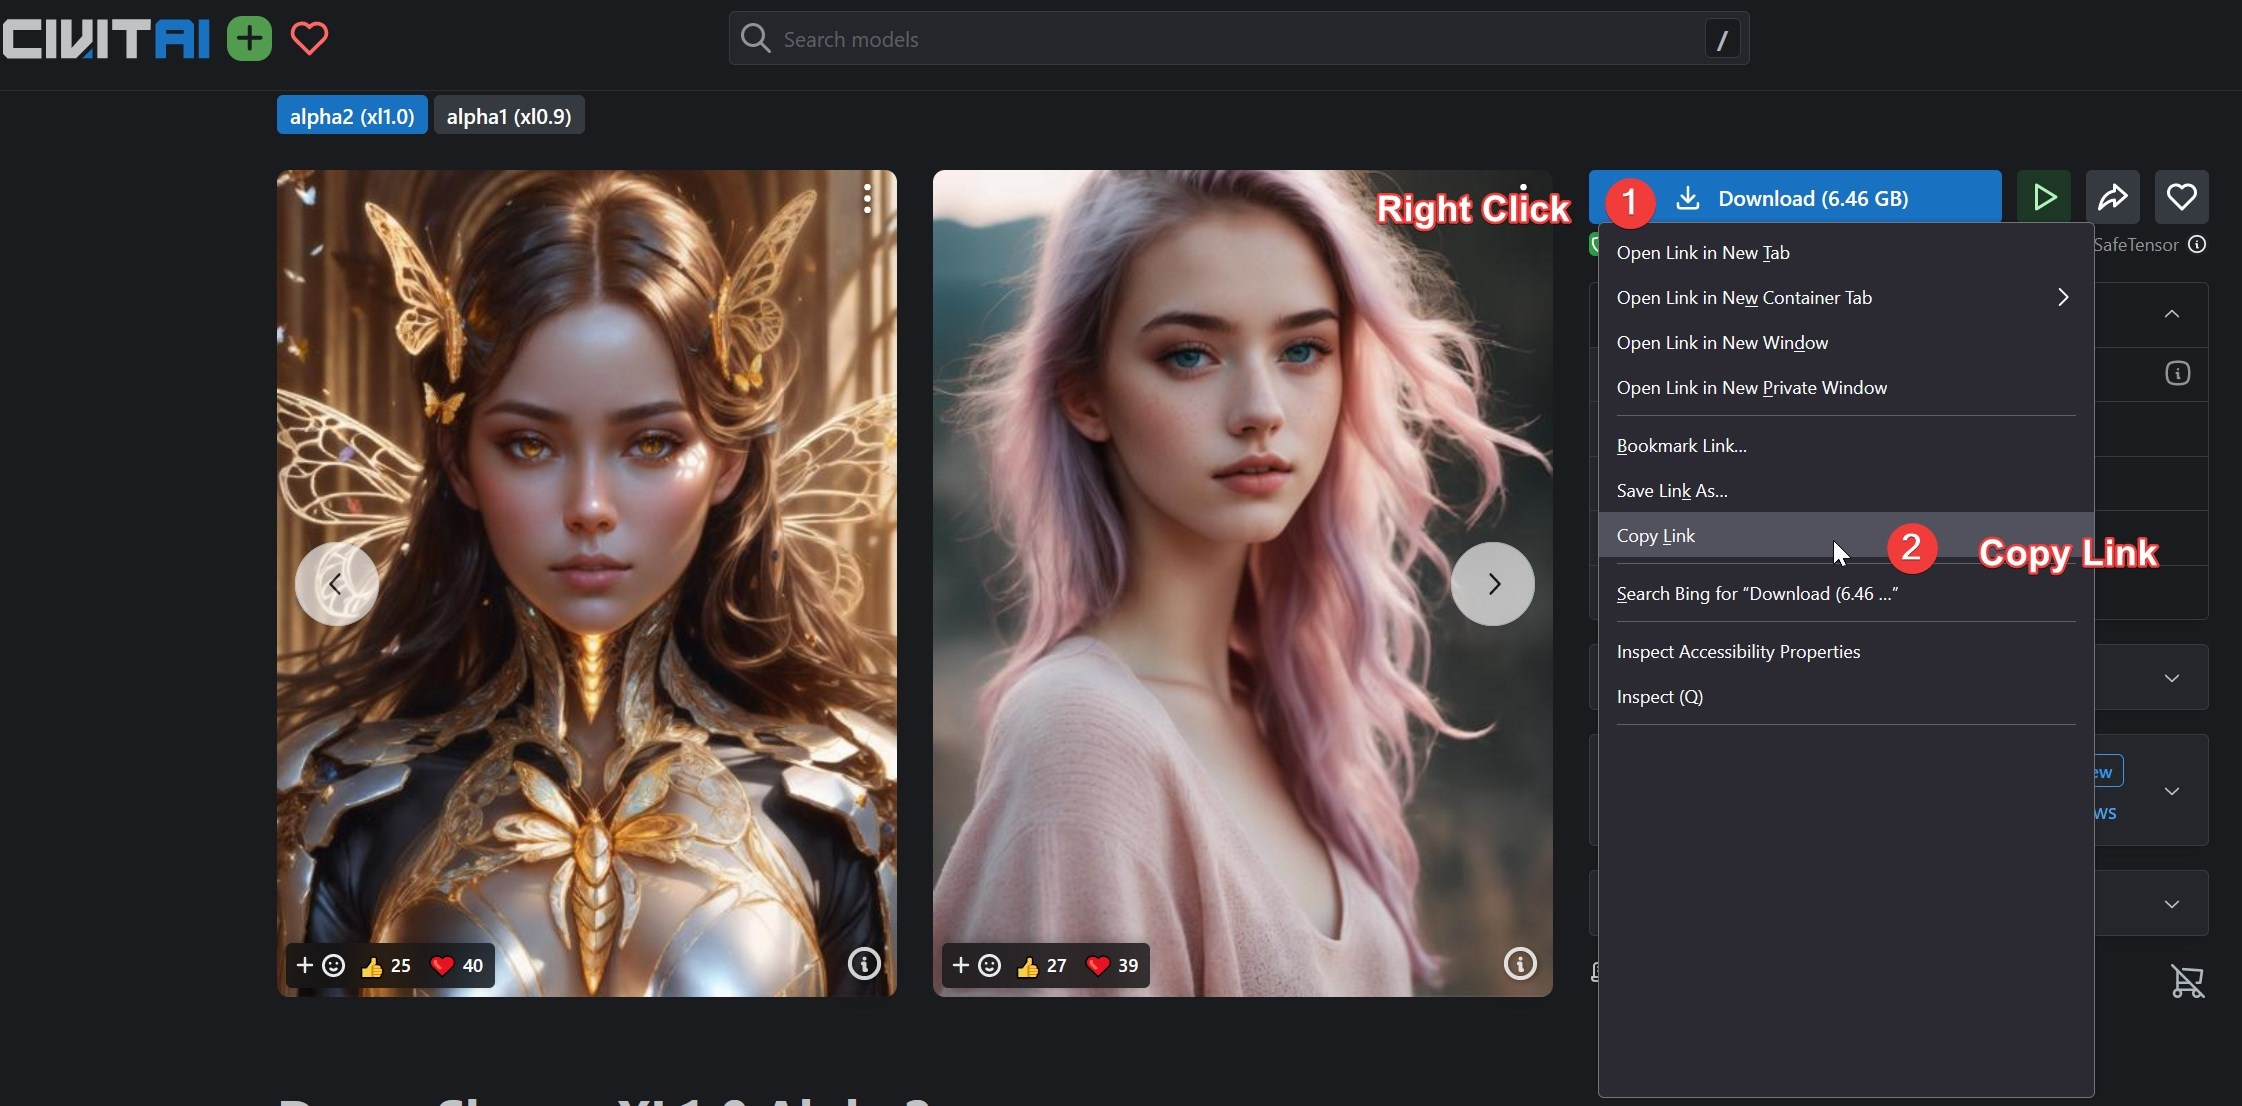

### Usage: Step 2

Put links the proper list below. Be sure to wrap the links around quotes and use commas as show below. Everything after the `#` are comments, and are only there for reference. The comments can be removed with no effect on the execution of the code.

In [ ]:
# Note: Everything after # on a line is ignored by the program. Good for commenting and documenting links, or saving links for later.
# Note: Ctrl+Enter or using the `Run` button on the menu will run the cells


sd_checkpoints = [
    "https://huggingface.co/Lykon/DreamShaper/resolve/main/DreamShaper_8_pruned.safetensors", # Dreamshaper 8 SD1.5.
    # "https://civitai.com/api/download/models/8641", # VirtuousMix
]

loras = [
    "https://civitai.com/api/download/models/87153", # Detail Enhancer
]

embeddings = [
    "https://huggingface.co/Lykon/DreamShaper/resolve/main/FastNegativeEmbedding.pt", # Fast Negative
    "https://huggingface.co/Lykon/DreamShaper/resolve/main/UnrealisticDream.pt", # Unrealistic Dream
    "https://huggingface.co/Lykon/DreamShaper/resolve/main/BadDream.pt", # Bad Dream
]

upscalers = [
    "https://huggingface.co/uwg/upscaler/resolve/main/ESRGAN/4x_fatal_Anime_500000_G.pth", # Fatal Anime 4x
]

controlnet = [
    # "https://huggingface.co/lllyasviel/ControlNet/resolve/main/models/control_sd15_depth.pth", # SD1.5 Depth
]

### Usage: Step 3
Simply run the below code to start downloading the files and putting them in the proper locations. <br>
*Note: If you want to modify the destination folders, modifying the cell directly below is recommended.*

In [ ]:
# Mapping for the lists made in the code cell above
directory_map = {
    '/workspace/stable-diffusion-webui/models/Stable-diffusion': sd_checkpoints,
    '/workspace/stable-diffusion-webui/models/Lora': loras,
    '/workspace/stable-diffusion-webui/models/ESRGAN': upscalers,
    '/workspace/stable-diffusion-webui/embeddings': embeddings,
    '/workspace/stable-diffusion-webui/extensions/sd-webui-controlnet/models/': controlnet,
}

In [ ]:
# Assigning file locations
url_dict = {}
for base_path, urls in directory_map.items():
    url_dict.update({url: base_path for url in urls})  

In [ ]:
%%capture

# Installing libraries
%pip install asyncio aiohttp aiofile nest-asyncio cchardet tqdm

In [ ]:
import time, pathlib, re
import asyncio # pip install asyncio
import aiohttp # pip install aiohttp, cchardet
import aiofile # pip install aiofile
import nest_asyncio # pip install nest-asyncio
import tqdm.asyncio # pip install tqdm

def download_files(url_dict, processes=5):
    """
    Downloads files asynchronously with asyncio.
    ::url_dict:: Dictionary of URLs to download
    ::processes:: The maximum amount of downloads to happen at once.
    This function returns some download stats that can be used with the print_stats function.
    
    
    Base Code from Source: https://gist.github.com/darwing1210/c9ff8e3af8ba832e38e6e6e347d9047a
    """
    sema = asyncio.BoundedSemaphore(processes)

    async def fetch_file(session, url_item):
        file_url, file_dir = url_item
        file_dir = pathlib.Path(file_dir)
        file_dir.mkdir(exist_ok=True)

        async with sema:
            async with session.get(file_url) as resp:
                if not resp.status == 200:
                    raise ValueError(f'Could not download from URL: {file_url}')
                
                file_name = file_url.split("/")[-1]
                if 'Content-Disposition' in list(resp.headers):
                    regex_search = re.search(
                        'filename\=[\\\'|"](.*)[\\\'|"]', resp.headers['Content-Disposition'])
                    if regex_search:
                        file_name = regex_search.group(1)
                file_name = file_dir / file_name
                
                size = int(resp.headers.get('content-length', 0)) or 0
                async with aiofile.async_open(file_name.absolute().as_posix(), mode="wb") as outfile:
                    async for chunk in resp.content.iter_chunked(1024):                    
                        await outfile.write(chunk)
        return size

    async def download_files():
        async with aiohttp.ClientSession() as session:
            tasks = [fetch_file(session, url_item) for url_item in url_dict.items()]
            return await tqdm.asyncio.tqdm.gather(*tasks, desc='Files Downloaded')

    start_time = time.time()
    loop = asyncio.get_event_loop()
    download_size = loop.run_until_complete(download_files())
    time_elapsed = time.time() - start_time
    return time_elapsed, sum(download_size)

def print_stats(time_elapsed, download_size):
    """
    Prints stats from the function download_files
    """
    
    out_str = 'Time elapsed: ' 
    if time_elapsed <= 60:
        out_str += f'{time_elapsed:.1f} seconds'
    else:
        out_str += f'{time_elapsed // 60:.0f} minutes and {time_elapsed % 60:.0f} seconds'

    out_str += '\n' + 'Download size: '
    if download_size >= 1e9:
        out_str += f'{download_size * 1e-9:.2f} GB'
    else:
        out_str += f'{download_size * 1e-6:.2f} MB'

    out_str += '\n' + f'Download Speed: {download_size * 1e-6 / time_elapsed:.2f} MB/s'
    print(out_str)

In [ ]:
if __name__ == '__main__':
    nest_asyncio.apply()
    time_elapsed, download_size = download_files(url_dict)
    print_stats(time_elapsed, download_size)

### Extra: Zipping Stable-Diffusion-Webui Outputs
Uncomment the lines of code below to zip all of the stable-diffusion-webui outputs for easier downloading.

In [ ]:
# import shutil

# shutil.make_archive('/home/outputs', 'zip', '/workspace/stable-diffusion-webui/outputs/') # shutil.make_archive(output_filename, 'zip', dir_name)